# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [175]:
# Set the theme here
THEME = 'eu_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [176]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [177]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [178]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 20 # This was lowered from 20 to 10 for gender_HU
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [179]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,u2017-11-15-13,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Józsa, István",M,1953.0,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt...",Tisztelt Képviselőtársaim! Szeretnék csatlako...,0.694824,3762
1,u2017-11-15-27,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,JOBBIK-frakció,A Jobbik Magyarországért Mozgalom parlamenti f...,Opposition,"Ander, Balázs",M,1976.0,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt...",Tisztelt Képviselőtársaim! Tisztelt Államtitk...,-0.725098,12772
2,u2017-11-15-37,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Fónagy, János",M,1942.0,"Köszönöm, elnök úr. Tisztelt Ház! Tisztelt Kép...",Tisztelt Ház! Tisztelt Képviselőtársaim! A tö...,0.320312,7822
3,u2017-11-15-41,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Heringes, Anita",F,1984.0,Nagyon szépen köszönöm a szót. Tisztelt Ház! A...,Tisztelt Ház! A javaslat célja az idegenforga...,-0.380615,3071
4,u2017-11-15-51,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Józsa, István",M,1953.0,"Köszönöm szépen, elnök úr, a lehetőséget. Ez e...","Ez egy olyan napirend, ami pontosan mutatja, ...",0.234009,6052


In [180]:
df['Speaker_party'].describe()

count               6594
unique                19
top       Fidesz-frakció
freq                2667
Name: Speaker_party, dtype: object

In [181]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [182]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.1)


In [183]:
pd.Series(new_topics).value_counts()

-1     1447
 0      242
 3      240
 1      206
 5      199
       ... 
 78      24
 65      24
 76      23
 72      22
 74      21
Length: 83, dtype: int64

In [184]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [185]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [186]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 83
Number of topics before: 83


In [187]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     2374
 50     185
 12     176
 42     170
 47     168
       ... 
 16      21
 0       20
 10      20
 8       20
 38      20
Length: 83, dtype: int64

In [188]:
topic_model.visualize_topics()

Topics over time

In [189]:
# Reference running time for this cell: 2min 30s

# topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [190]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [191]:
# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [192]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

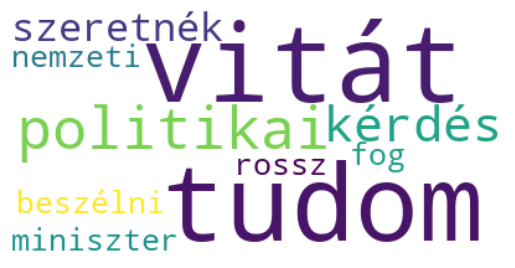

In [193]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=3)

In [194]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [195]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['közbeszerzési',
 'javaslat',
 'nyilván',
 'törvényjavaslat',
 'egyetemek',
 'vita',
 'elektronikus',
 'szeretnék',
 'komoly',
 'államtitkár']

In [196]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-frakció' or 'JOBBIK-frakció'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-frakció|JOBBIK-frakció'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-frakció,JOBBIK-frakció,OTHER
topic,,,
0,58,69,108
1,89,39,77
2,60,32,105
3,67,44,127
4,56,9,98
5,60,24,112
6,140,11,40
7,78,23,24
8,52,17,50


In [197]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-frakció,JOBBIK-frakció,OTHER
topic,,,
0,7.8,25.1,13.7
1,11.9,14.2,9.8
2,8.0,11.6,13.3
3,9.0,16.0,16.1
4,7.5,3.3,12.4
5,8.0,8.7,14.2
6,18.7,4.0,5.1
7,10.4,8.4,3.0
8,7.0,6.2,6.3


In [198]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-frakció,JOBBIK-frakció,OTHER,keywords
topic,,,,
0,7.8,25.1,13.7,"[közbeszerzési, javaslat, nyilván, törvényjava..."
1,11.9,14.2,9.8,"[köztársaság, horvátország, partnerségi, beruh..."
2,8.0,11.6,13.3,"[dr, tudom, jegybank, ellenzéki, egyszer, képv..."
3,9.0,16.0,16.1,"[vitát, tudom, politikai, kérdés, szeretnék, m..."
4,7.5,3.3,12.4,"[koronavírus, vakcinát, kínai, baloldal, védek..."
5,8.0,8.7,14.2,"[költségvetést, gdp, milliárd, növekedés, álla..."
6,18.7,4.0,5.1,"[illegális, schengeni, déli, migránsok, határo..."
7,10.4,8.4,3.0,"[állatok, krízisbiztosítási, családi, vidék, é..."
8,7.0,6.2,6.3,"[akkreditációs, törvényjavaslat, víziközmű, ci..."


In [199]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-frakció,JOBBIK-frakció,OTHER
0,0,24.7,29.4,46.0
1,1,43.4,19.0,37.6
2,2,30.5,16.2,53.3
3,3,28.2,18.5,53.4
4,4,34.4,5.5,60.1
5,5,30.6,12.2,57.1
6,6,73.3,5.8,20.9
7,7,62.4,18.4,19.2
8,8,43.7,14.3,42.0
9,9,61.5,4.9,33.6


Calculate mean sentiment for each topic per party

In [200]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-frakció' or 'JOBBIK-frakció'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-frakció|JOBBIK-frakció'), 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-frakció,JOBBIK-frakció,OTHER
topic,,,
0,-0.04,-0.31,-0.37
1,0.31,0.28,0.37
2,-0.52,-0.61,-0.62
3,-0.43,-0.45,-0.38
4,-0.34,-0.20,-0.34
5,-0.01,-0.53,-0.36
6,-0.05,-0.29,-0.22
7,-0.03,-0.44,-0.26
8,0.10,-0.19,-0.23
